<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Выявление-зависимости-ежедневного-количества-обращений-с-каналов-органики-от-спроса" data-toc-modified-id="Выявление-зависимости-ежедневного-количества-обращений-с-каналов-органики-от-спроса-1">Выявление зависимости ежедневного количества обращений с каналов органики от спроса</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1.1">Постановка задачи</a></span></li><li><span><a href="#Подключение-к-базе-данных-и-загрузка-данных" data-toc-modified-id="Подключение-к-базе-данных-и-загрузка-данных-1.2">Подключение к базе данных и загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-1.3">Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Формирование-общей-сводной-таблицы" data-toc-modified-id="Формирование-общей-сводной-таблицы-1.4">Формирование общей сводной таблицы</a></span></li><li><span><a href="#Выявление-взаимосвязей" data-toc-modified-id="Выявление-взаимосвязей-1.5">Выявление взаимосвязей</a></span></li></ul></li></ul></div>

# Выявление зависимости ежедневного количества обращений с каналов органики от спроса 

## Постановка задачи

В нашем распоряжении есть два датасета:

1. <i> 'communications.csv' </i> - в котором хранится информация обо всех обращениях пользователей, произошедших за определенный период, в разбивке по дням и брендам. 

2. <i> 'phrases_shows.csv'</i> - содержит информацию о количестве показов списка запросов по брендам: дата, бренд, id поисковой фразы и количество ее показов (значение в столбце shows показывает скользящую сумму количества показов по окну за предшествующий месяц)

Нам необходимо проанализировать собранные данные на предмет их однородности и наличия аномалий, а затем проверить, существует ли взаимосвязь между количеством обращений с органики по бренду и количеством показов соответствующих поисковых фраз.


## Подключение к базе данных и загрузка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from scipy.stats.stats import pearsonr

In [2]:
# Загрузим таблицу с информацией об обращениях пользователей
communications = pd.read_csv('communications.csv')
communications.head()

,communication_id,date_time,brand_id,source_type
0,11394944,2021-06-01 00:41:20.000,1,other
1,11395343,2021-06-01 01:33:09.000,1,other
2,11397299,2021-06-01 06:02:29.000,1,other
3,1656035517,2021-06-01 06:09:14.000,0,other
4,11397353,2021-06-01 06:13:20.000,1,other


In [3]:
# изучим основные сведения о таблице
communications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25162 entries, 0 to 25161
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   communication_id  25162 non-null  int64 
 1   date_time         25162 non-null  object
 2   brand_id          25162 non-null  int64 
 3   source_type       25162 non-null  object
dtypes: int64(2), object(2)
memory usage: 786.4+ KB


In [4]:
# Загрузим таблицу с выгрузкой по частотности запросов в разбивке по брендам и дням за тот же период
shows = pd.read_csv('phrases_shows.csv', sep=';')

# и выведем первые строки
shows.head()

,date,brand_id,phrase_id,shows
0,2021-06-01,0,0,576
1,2021-06-01,0,1,90
2,2021-06-01,0,2,55
3,2021-06-01,0,3,144
4,2021-06-01,0,4,8


In [5]:
shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2668 entries, 0 to 2667
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       2668 non-null   object
 1   brand_id   2668 non-null   int64 
 2   phrase_id  2668 non-null   int64 
 3   shows      2668 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 83.5+ KB


In [6]:
# в обеих таблицах приведем столбцы с датами к единому виду и преобразуем к типу datetime
communications['date_time'] = pd.to_datetime(communications['date_time'], format='%Y-%m-%d %H:%M:%S.%f').dt.date
communications['date_time'] = pd.to_datetime(communications['date_time'])
communications = communications.rename(columns = {'date_time': 'date'})

shows['date'] = pd.to_datetime(shows['date'])

In [7]:
# проверим уникальность всех строк в таблицах, а также уникальность id обращений
shows.duplicated().sum(), communications.duplicated().sum(), communications['communication_id'].duplicated().sum()

(0, 0, 0)

In [8]:
#  проверим за какой период имеем данные в таблицах (нужно убедиться, что эти периоды совпадают)
communications['date'].min(), communications['date'].max()

(Timestamp('2021-06-01 00:00:00'), Timestamp('2021-08-31 00:00:00'))

In [9]:
shows['date'].min(), shows['date'].max()

(Timestamp('2021-06-01 00:00:00'), Timestamp('2021-08-31 00:00:00'))

## Исследовательский анализ данных (EDA)

Поскольку в данном исследовании нас интересуют только обращения из поисковых запросов, оставим в таблице communications только их. 

In [10]:
communications = communications[communications['source_type'] == 'organic']


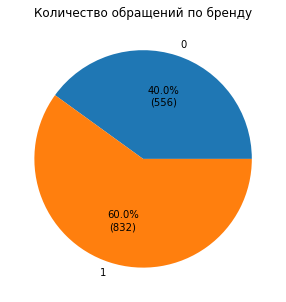

In [11]:
# визуализируем соотношение количества обращений по бренду
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(1,1,1)

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


vals = communications.groupby('brand_id')['communication_id'].count().reset_index()['communication_id']
labels = communications.groupby('brand_id')['communication_id'].count().reset_index()['brand_id']

ax1.set_title('Количество обращений по бренду')
ax1.pie(vals, labels=labels, autopct=lambda pct: func(pct, vals))       

plt.show()

Посмотрим на графике, как по дням меняется количество обращений по каждому бренду.

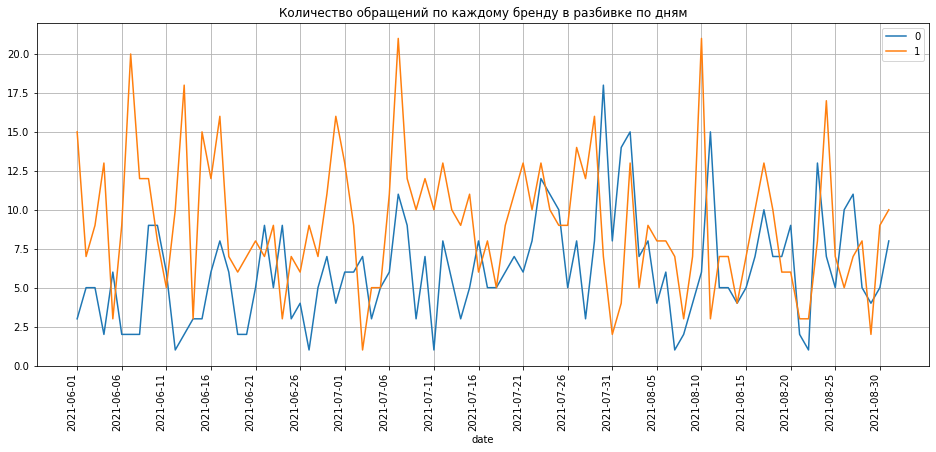

In [12]:
fig = plt.figure(figsize=(16, 7))

communications[communications['brand_id'] == 0].groupby('date')['communication_id'].count().plot(label='0')
communications[communications['brand_id'] == 1].groupby('date')['communication_id'].count().plot(label='1')

plt.title('Количество обращений по каждому бренду в разбивке по дням')
plt.xticks(communications['date'].unique()[::5], rotation=90)
plt.legend()
plt.grid()
plt.show()

In [13]:
(communications[communications['brand_id'] == 0].groupby('date')['communication_id'].count().mean(),
communications[communications['brand_id'] == 1].groupby('date')['communication_id'].count().mean())

(6.1098901098901095, 9.054347826086957)

Обращений по  первому бренду больше, чем по нулевому (в среднем по 0  - 6 обращений в день, по 1 - 9.). Также на графике первого бренда, больше резких переходов между значениями. 


Исследуем данные в таблице с показами поисковых запросов. Выясним, сколько поисковых фраз соответствует каждому бренду.

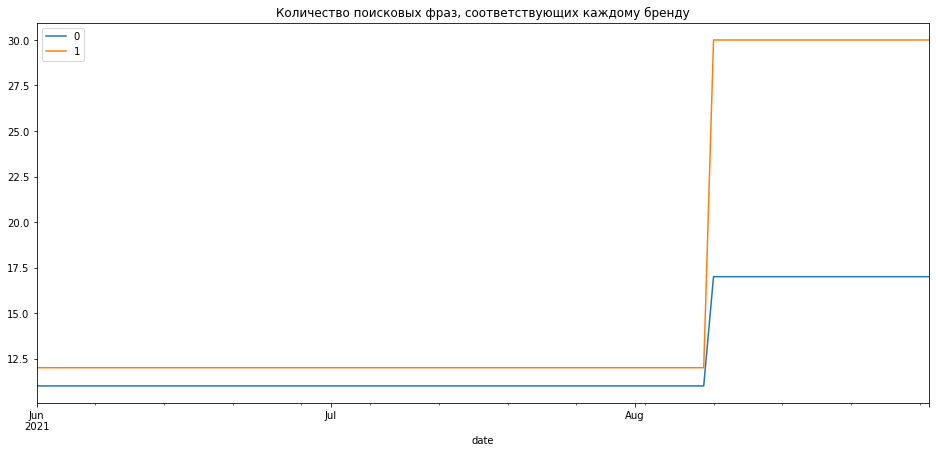

In [14]:
fig = plt.figure(figsize=(16, 7))
shows.pivot_table(index='date', columns='brand_id', values='phrase_id', aggfunc='count')[0].plot(label='0')
shows.pivot_table(index='date', columns='brand_id', values='phrase_id', aggfunc='count')[1].plot(label='1')

plt.title('Количество поисковых фраз, соответствующих каждому бренду')
plt.legend()
plt.show()

У первого бренда больше поисковых фраз. Можем заметить, что после 9 августа количество поисковых фраз по обоим брендам увеличилось. С 11 до 17 штук для нулевого бренда и c 12 до 30 штук для первого. 

В таблице с показами рассчитаем скользящее среднее и добавим в отдельный столбец.

In [15]:
shows['rolling_avg'] = shows['shows']/30
shows.head()

,date,brand_id,phrase_id,shows,rolling_avg
0,2021-06-01,0,0,576,19.200000
1,2021-06-01,0,1,90,3.000000
2,2021-06-01,0,2,55,1.833333
3,2021-06-01,0,3,144,4.800000
4,2021-06-01,0,4,8,0.266667


Посмотрим, насколько равномерно распределены скользящие средние на гистограмме.

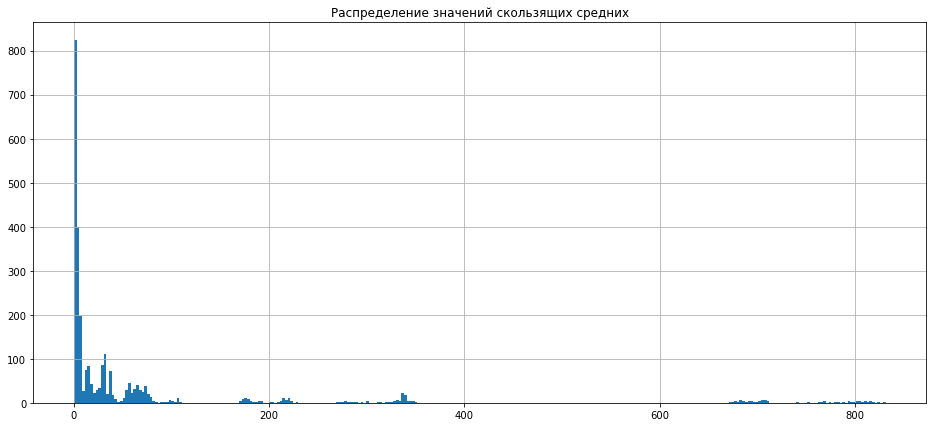

In [16]:
fig = plt.figure(figsize=(16, 7))
shows['rolling_avg'].hist(bins=300)


plt.title('Распределение значений скользящих средних')
plt.show()

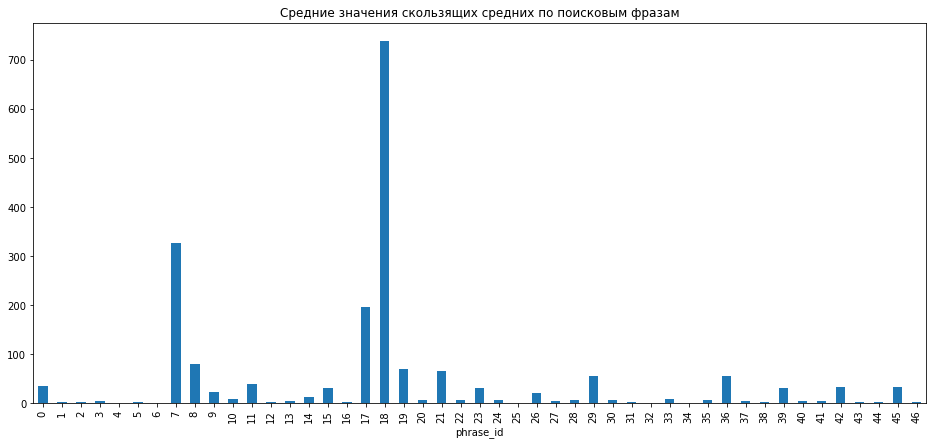

In [17]:
fig = plt.figure(figsize=(16, 7))
shows.groupby('phrase_id')['rolling_avg'].mean().plot(kind='bar')
plt.title('Средние значения скользящих средних по поисковым фразам')
plt.show()

Можем заметить, что большинство значений не превышают 300, но есть небольшое количество бОльших значений, которые могут исказить результаты исследования. Причем, судя по второму графику они относятся к ключевым фразам № 7 и № 18. 

## Формирование общей сводной таблицы

In [18]:
# посчитаем суммарную скользящую сумму показов по дням, сгруппировав их по id брендов
pivot_brand = shows.pivot_table(index='date', 
                          columns='brand_id', 
                          values='shows',      
                          aggfunc='sum'
                          ).reset_index().rename(columns={0:'roll_sum_0',
                                                         1:'roll_sum_1'})
pivot_brand.head()

brand_id,date,roll_sum_0,roll_sum_1
0,2021-06-01,11590,32641
1,2021-06-02,11533,32649
2,2021-06-03,11615,32784
3,2021-06-04,11725,33072
4,2021-06-05,11869,33185


 Добавим столбец, где рассчитаем разницу скользящих сумм за текущую дату и предыдущий день. Это значение будет показывать изменение количества показов. 

In [19]:
s = pivot_brand['roll_sum_0'].diff()
pivot_brand['diff_shows_0'] = s.mask(s.isna(), pivot_brand['roll_sum_0'])

s = pivot_brand['roll_sum_1'].diff()
pivot_brand['diff_shows_1'] = s.mask(s.isna(), pivot_brand['roll_sum_1'])

# еще посчитаем и добавим в тадлицу скользящее среднее показов по брендам.
pivot_brand['roll_avg_0'] = round(pivot_brand['roll_sum_0']/30, 2)
pivot_brand['roll_avg_1'] = round(pivot_brand['roll_sum_1']/30, 2)

pivot_brand.head()

brand_id,date,roll_sum_0,roll_sum_1,diff_shows_0,diff_shows_1,roll_avg_0,roll_avg_1
0,2021-06-01,11590,32641,11590.0,32641.0,386.33,1088.03
1,2021-06-02,11533,32649,-57.0,8.0,384.43,1088.30
2,2021-06-03,11615,32784,82.0,135.0,387.17,1092.80
3,2021-06-04,11725,33072,110.0,288.0,390.83,1102.40
4,2021-06-05,11869,33185,144.0,113.0,395.63,1106.17


Посмотрим на графике, как по дням менялось количество показов в разбивке по брендам.

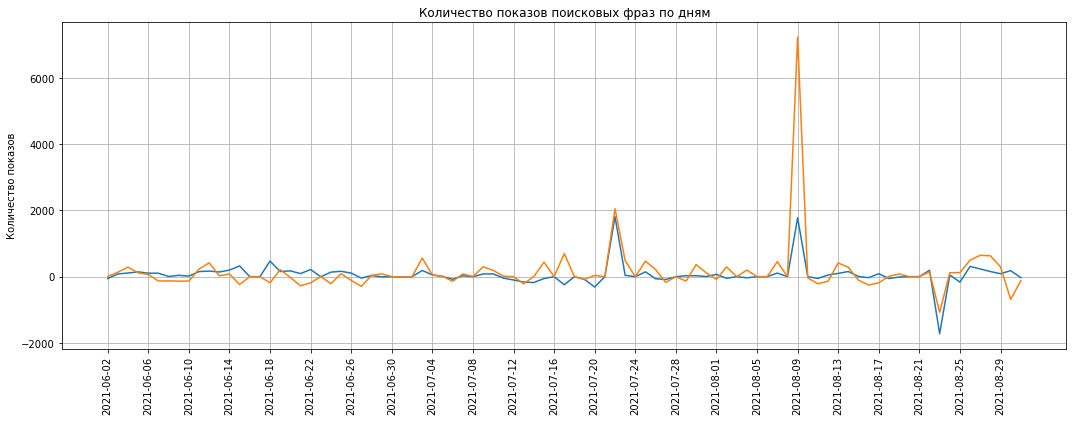

In [32]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,1,1)


sns.lineplot(x="date", 
            y="diff_shows_0", 
            data=pivot_brand[pivot_brand['date'] > '2021-06-01'], 
            ax=ax1)

sns.lineplot(x="date", 
            y="diff_shows_1", 
            data=pivot_brand[pivot_brand['date'] > '2021-06-01'], 
            ax=ax1)
ax1.set_title('Количество показов поисковых фраз по дням')
ax1.set_xticks(pivot_brand[pivot_brand['date'] > '2021-06-01']['date'][::4])
ax1.tick_params(axis='x', rotation=90)
ax1.grid()
ax1.set_xlabel('')
ax1.set_ylabel('Количество показов')

plt.show()

Можем заметить, что 9 августа произошел резкий выброс запросов по всем поисковым фразам. 

Соберем сводную информацию по обращениям. Посчитаем количество обращений по дням, сгруппировав их по id брендов. 

In [21]:
pivot_brand = pivot_brand.merge(communications.pivot_table(index='date', 
                                                           values='communication_id', 
                                                           columns='brand_id', 
                                                           aggfunc='count').rename(columns={0: 'comm_0',
                                                                                            1: 'comm_1'}).reset_index(),
                    on='date')
pivot_brand.head()

brand_id,date,roll_sum_0,roll_sum_1,diff_shows_0,diff_shows_1,roll_avg_0,roll_avg_1,comm_0,comm_1
0,2021-06-01,11590,32641,11590.0,32641.0,386.33,1088.03,3.0,15.0
1,2021-06-02,11533,32649,-57.0,8.0,384.43,1088.30,5.0,7.0
2,2021-06-03,11615,32784,82.0,135.0,387.17,1092.80,5.0,9.0
3,2021-06-04,11725,33072,110.0,288.0,390.83,1102.40,2.0,13.0
4,2021-06-05,11869,33185,144.0,113.0,395.63,1106.17,6.0,3.0


Для обращений тоже посчитаем ежедневную разницу. Только в этом случае мы оперируем данными за текущую дату, поэтому "смещать" таблицу не будем. 

In [22]:
s = pivot_brand['comm_0'].diff()
pivot_brand['diff_comm_0'] = s.mask(s.isna(), pivot_brand['comm_0'])

s = pivot_brand['comm_1'].diff()
pivot_brand['diff_comm_1'] = s.mask(s.isna(), pivot_brand['comm_1'])
pivot_brand.head()

brand_id,date,roll_sum_0,roll_sum_1,diff_shows_0,diff_shows_1,roll_avg_0,roll_avg_1,comm_0,comm_1,diff_comm_0,diff_comm_1
0,2021-06-01,11590,32641,11590.0,32641.0,386.33,1088.03,3.0,15.0,3.0,15.0
1,2021-06-02,11533,32649,-57.0,8.0,384.43,1088.30,5.0,7.0,2.0,-8.0
2,2021-06-03,11615,32784,82.0,135.0,387.17,1092.80,5.0,9.0,0.0,2.0
3,2021-06-04,11725,33072,110.0,288.0,390.83,1102.40,2.0,13.0,-3.0,4.0
4,2021-06-05,11869,33185,144.0,113.0,395.63,1106.17,6.0,3.0,4.0,-10.0


Также создадим сводную таблицу динамики показов в разбивке по поисковым фразам.

In [23]:
pivot_phrases = shows.pivot_table(index='date',
                                 columns='phrase_id',
                                 values='shows',
                                 aggfunc='sum').reset_index()
pivot_phrases.head()

phrase_id,date,0,1,2,3,4,5,6,7,8,...,37,38,39,40,41,42,43,44,45,46
0,2021-06-01,576.0,90.0,55.0,144.0,8.0,66.0,3.0,8115.0,1940.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-02,580.0,83.0,52.0,147.0,8.0,66.0,4.0,8092.0,1929.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-03,585.0,81.0,49.0,146.0,8.0,66.0,4.0,8174.0,1938.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-04,611.0,81.0,49.0,149.0,8.0,66.0,4.0,8228.0,1966.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-05,648.0,80.0,48.0,153.0,8.0,68.0,3.0,8300.0,1980.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
for x in pivot_phrases.columns:
    if type(x) == int:
        s = pivot_phrases[x].diff()
        pivot_phrases[x] = s.mask(s.isna(), pivot_phrases[x])

In [25]:
pivot_phrases.head()

phrase_id,date,0,1,2,3,4,5,6,7,8,...,37,38,39,40,41,42,43,44,45,46
0,2021-06-01,576.0,90.0,55.0,144.0,8.0,66.0,3.0,8115.0,1940.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-06-02,4.0,-7.0,-3.0,3.0,0.0,0.0,1.0,-23.0,-11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-06-03,5.0,-2.0,-3.0,-1.0,0.0,0.0,0.0,82.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-06-04,26.0,0.0,0.0,3.0,0.0,0.0,0.0,54.0,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-06-05,37.0,-1.0,-1.0,4.0,0.0,2.0,-1.0,72.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Выявление взаимосвязей

Рассчитаем коэффиценты корреляции для интересующих нас выборок. Проверим гипотезы о истинном коэффиценте корреляции для генеральной совокупности.

Сформулируем нулевую и альтернативную гипотезы:

Н0: нет различия между выборочным коэфф.корреляции и коэфф.корреляции генеральной совокупности,

Н1: есть различие между выборочным коэфф.корреляции и коэфф.корреляции генеральной совокупности.

In [26]:
# для удобства расчетов коэффицентов корреляции реализуем функцию

pivot_brand = pivot_brand.fillna(0)
pivot_phrases = pivot_phrases.fillna(0)

def calculate_corr(val1, val2):
    alpha = 0.05
    corr, p = pearsonr(val1, val2)
    print('Коэффицент корреляции: ', round(corr, 3),', p-value = ', round(p, 3))
    if p < alpha:
        print('Отвергаем нулевую гипотезу: различия статистически значимы')
    else:
        print('Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы')

In [27]:
print('Между динамикой показов и обращениями по бренду 0:')
calculate_corr(pivot_brand['diff_shows_0'], pivot_brand['diff_comm_0'])
print()
print('Между динамикой показов и обращениями по бренду 1:')
calculate_corr(pivot_brand['diff_shows_1'], pivot_brand['diff_comm_1'])

Между динамикой показов и обращениями по бренду 0:
Коэффицент корреляции:  0.035 , p-value =  0.742
Не получилось отвергнуть нулевую гипотезу: различия статистически не значимы

Между динамикой показов и обращениями по бренду 1:
Коэффицент корреляции:  0.269 , p-value =  0.009
Отвергаем нулевую гипотезу: различия статистически значимы


По рассчитанным коэффицентам  мы видим, что в разбивке по брендам коэффиценты корреляции немного различаются. Для бренда 0 наблюдается близкая к нулю корреляция, а для бренда 1 она равна 0.27. При этом для нулевого бренда статистический тест не выявил значимых различий, а для первого бренда есть основания отвергнуть нулевую гипотезу в пользу альтернативной.

Далее рассчитаем коэффиценты корреляции для отдельных поисковых фраз и визуализируем их на графике.

In [28]:
corrs = {}
pvalues = {}
for x in pivot_phrases.columns:
    if type(x) == int:
        corrs[str(x)] = pearsonr(pivot_phrases[x], pivot_brand['diff_comm_0']+pivot_brand['diff_comm_1'])[0]
        pvalues[str(x)] = pearsonr(pivot_phrases[x], pivot_brand['diff_comm_0']+pivot_brand['diff_comm_1'])[1]
        

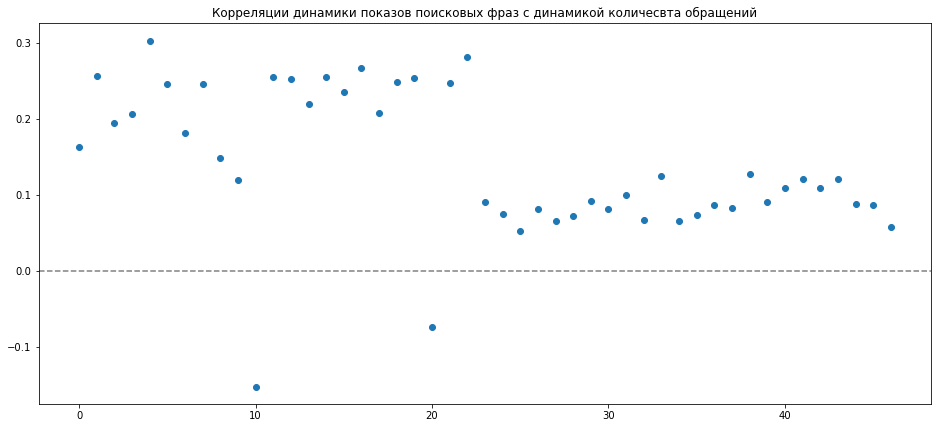

In [29]:
fig = plt.figure(figsize=(16, 7))

plt.plot(corrs.values(), linestyle='', marker='o')
plt.plot(0)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title('Корреляции динамики показов поисковых фраз с динамикой количесвта обращений')
plt.show()


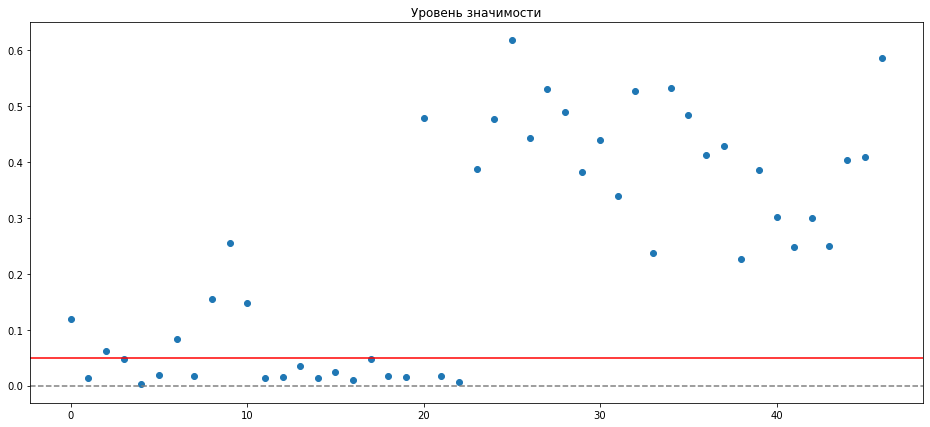

In [30]:
fig = plt.figure(figsize=(16, 7))

plt.plot(pvalues.values(), linestyle='', marker='o')
plt.plot(0)
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=0.05, color='red')
plt.title('Уровень значимости')
plt.show()


По графику видим, что сильной корреляции ни по одной из фраз нет. В некоторых случаях наблюдается прямая, а в некоторых - обратная корреляция, но она всегда довольно слабая. По второму графику видно, что уровень значимости рассчитанных коэффицентов в некоторых случаях выше alpha = 0.05(красная линия), значит статистически значимых различий нет и нет оснований считать, что коэффиценты рассчитанный по этим выборкам и коэффиценты корреляции ген.совокупности значительно отличаются. В других же случаях статистические разлиичя значимы, а значит и коэффиценты корреляции выборок и  ген.совокупностей все же отличаются.